# FlowSim vs NS3: Per-Flow FCT Prediction Analysis (CORRECTED)

This notebook compares per-flow Flow Completion Time (FCT) predictions between FlowSim and NS3 using **start_time + FCT sorting** for proper flow matching.

**Key Insight**: Match flows by sorting both datasets by start_time first, then by FCT within each start_time group. This aligns flows that represent the same logical communication patterns.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

## Load and Match FCT Data by Start Time + FCT Sorting

In [23]:
def load_fct_data(filepath):
    """
    Load FCT data for sorting-based matching.
    Format: src_node dst_node src_port dst_port msg_size start_time fct_ns standalone_fct flow_id
    """
    data = []
    with open(filepath, 'r') as f:
        for index, line in enumerate(f):
            if line.strip():
                parts = line.strip().split()
                if len(parts) >= 9:
                    # Convert hex src/dst to int, extract key info
                    src = int(parts[0], 16)
                    dst = int(parts[1], 16) 
                    msg_size = int(parts[4])      # Column 5: message size
                    start_time = int(parts[5])    # Column 6: start time
                    fct_ns = int(parts[6])        # Column 7: actual FCT
                    flow_id = int(parts[8])       # Column 9: flow_id (for reference only)
                    data.append([index, fct_ns, src, dst, msg_size, start_time, flow_id])
    
    return pd.DataFrame(data, columns=['original_index', 'fct_ns', 'src_node', 'dst_node', 'msg_size', 'start_time', 'flow_id'])

# Load data and sort by start_time + FCT for proper matching
print("Loading FCT data...")
ns3_data = load_fct_data('results/ns3/ns3_fct.txt')
flowsim_data = load_fct_data('results/flowsim/flowsim_fct.txt')

print(f"NS3 flows: {len(ns3_data)}")
print(f"FlowSim flows: {len(flowsim_data)}")

# Sort both datasets by start_time, message_size, then FCT for proper matching
print(f"\nSorting flows by start_time + msg_size + FCT for proper matching...")
ns3_sorted = ns3_data.sort_values(['flow_id']).reset_index(drop=True)
flowsim_sorted = flowsim_data.sort_values(['flow_id']).reset_index(drop=True)

print(f"NS3 start_time range: {ns3_sorted['start_time'].min()} - {ns3_sorted['start_time'].max()}")
print(f"FlowSim start_time range: {flowsim_sorted['start_time'].min()} - {flowsim_sorted['start_time'].max()}")

# Check message size distribution
ns3_msg_sizes = ns3_sorted['msg_size'].unique()
flowsim_msg_sizes = flowsim_sorted['msg_size'].unique()
print(f"\nMessage size distribution:")
print(f"NS3 message sizes: {sorted(ns3_msg_sizes)} ({len(ns3_msg_sizes)} unique)")
print(f"FlowSim message sizes: {sorted(flowsim_msg_sizes)} ({len(flowsim_msg_sizes)} unique)")
print(f"Message sizes match: {set(ns3_msg_sizes) == set(flowsim_msg_sizes)}")

# Match flows by sorted order (flows with same start_time + FCT rank)
min_flows = min(len(ns3_sorted), len(flowsim_sorted))
print(f"Can match {min_flows} flows")

# Create matched dataframe
matched_data = []
for i in range(min_flows):
    ns3_flow = ns3_sorted.iloc[i]
    flowsim_flow = flowsim_sorted.iloc[i]
    
    matched_data.append({
        'index': i,
        'ns3_fct': ns3_flow['fct_ns'],
        'flowsim_fct': flowsim_flow['fct_ns'],
        'ns3_src': ns3_flow['src_node'],
        'ns3_dst': ns3_flow['dst_node'],
        'flowsim_src': flowsim_flow['src_node'],
        'flowsim_dst': flowsim_flow['dst_node'],
        'ns3_start': ns3_flow['start_time'],
        'flowsim_start': flowsim_flow['start_time'],
        'msg_size': ns3_flow['msg_size']
    })

merged_df = pd.DataFrame(matched_data)

# Calculate relative error: (FlowSim - NS3) / NS3
merged_df['relative_error'] = abs(merged_df['flowsim_fct'] - merged_df['ns3_fct']) / merged_df['ns3_fct'] * 100

print(f"Successfully matched {len(merged_df)} flows")
print(f"Mean relative error: {merged_df['relative_error'].mean():.4f}%")
print(f"Median relative error: {merged_df['relative_error'].median():.4f}%")

# Show sample comparisons
print(f"\n🔍 Sample flow comparisons (after sorting by start_time + msg_size + FCT):")
for i in range(min(10, len(merged_df))):
    row = merged_df.iloc[i]
    start_diff = abs(row['ns3_start'] - row['flowsim_start'])
    msg_size_kb = int(row['msg_size']) // 1024
    print(f"  Flow {i:3d}: NS3={int(row['ns3_fct']):5d}ns, FlowSim={int(row['flowsim_fct']):5d}ns, error={row['relative_error']:+.4f}, size={msg_size_kb}KB, start_diff={start_diff:.0f}ns")

# Error distribution
errors = merged_df['relative_error']
print(f"\n📈 Error distribution:")
print(f"   Flows with <10% error: {(abs(errors) < 10).sum():,} ({(abs(errors) < 10).mean()*100:.1f}%)")
print(f"   Flows with <1% error: {(abs(errors) < 1).sum():,} ({(abs(errors) < 1).mean()*100:.1f}%)")

Loading FCT data...
NS3 flows: 30720
FlowSim flows: 30720

Sorting flows by start_time + msg_size + FCT for proper matching...
NS3 start_time range: 559010 - 2059911
FlowSim start_time range: 559010 - 1823212

Message size distribution:
NS3 message sizes: [131072] (1 unique)
FlowSim message sizes: [131072] (1 unique)
Message sizes match: True
Can match 30720 flows
Successfully matched 30720 flows
Mean relative error: 38.3902%
Median relative error: 29.6671%

🔍 Sample flow comparisons (after sorting by start_time + msg_size + FCT):
  Flow   0: NS3= 2854ns, FlowSim= 3108ns, error=+8.8998, size=128KB, start_diff=0ns
  Flow   1: NS3= 2854ns, FlowSim= 3108ns, error=+8.8998, size=128KB, start_diff=0ns
  Flow   2: NS3= 2854ns, FlowSim= 3108ns, error=+8.8998, size=128KB, start_diff=0ns
  Flow   3: NS3= 2854ns, FlowSim= 3108ns, error=+8.8998, size=128KB, start_diff=0ns
  Flow   4: NS3= 2854ns, FlowSim= 3108ns, error=+8.8998, size=128KB, start_diff=0ns
  Flow   5: NS3= 2854ns, FlowSim= 3108ns, e

## FlowSim vs NS3 FCT Prediction Analysis

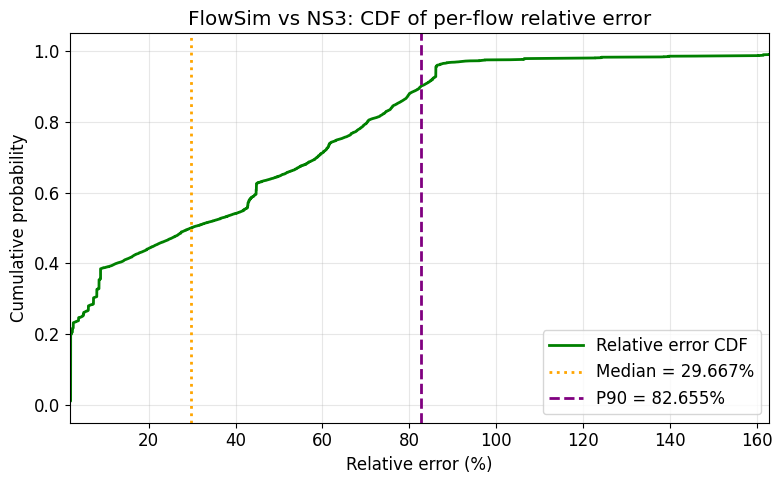

In [24]:
# Assumes merged_df with column 'relative_error' already prepared above
errors_pct = merged_df['relative_error']  # already in percent in this notebook
sorted_errors = np.sort(errors_pct)
cdf_y = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

plt.figure(figsize=(8, 5))
plt.plot(sorted_errors, cdf_y, linewidth=2, color='green', label='Relative error CDF')

# Markers: median and P90
med = np.median(errors_pct)
p90 = np.percentile(errors_pct, 90)
plt.axvline(med, color='orange', linestyle=':', linewidth=2, label=f'Median = {med:.3f}%')
plt.axvline(p90, color='purple', linestyle='--', linewidth=2, label=f'P90 = {p90:.3f}%')

plt.xlabel('Relative error (%)')
plt.ylabel('Cumulative probability')
plt.title('FlowSim vs NS3: CDF of per-flow relative error')
plt.grid(True, alpha=0.3)
plt.legend()

# Focus x-range to 1st–99th percentiles
x1 = np.percentile(errors_pct, 1)
x99 = np.percentile(errors_pct, 99)
plt.xlim(x1, x99)
plt.tight_layout()
plt.show()
